In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np

import mahotas as mh

from skimage import io
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local, threshold_adaptive
from skimage.filters import sobel

path_comm = "/media/ula/D/mikroskop/CA1/split_pages/MAX_CA1_glass_28_rat_1_hipp_left_skan_2019-08-05_page"

dapi_path = path_comm + "1.tif"
homer_path = path_comm + "2.tif"
arc_path = path_comm + "3.tif"

#tif_path = "/media/ula/D/adam_catfish/catfish_1908/first_page.png"

In [2]:
import PIL as Image

Image.MAX_IMAGE_PIXELS = 208956970

In [3]:
Image.MAX_IMAGE_PIXELS

208956970

In [4]:
import skimage
Image.__file__

'/home/ula/anaconda3/lib/python3.6/site-packages/PIL/__init__.py'

In [5]:
image = io.imread(dapi_path)

/home/ula/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2416: UserWarning: invalid ImageJ metadata or corrupted file
  warnings.warn("invalid ImageJ metadata or corrupted file")


In [6]:
def get_frac_thresh(arr, frac):
    min_lum = np.min(arr)
    max_lum = np.max(arr)
    return min_lum + frac*(max_lum - min_lum)

In [1]:
def thresholding_and_segmentation(img_path):
    
    image = io.imread(img_path)
    
    image = rgb2gray(image)
    
    radius = 30
    selem = disk(radius)

    thre = get_frac_thresh(image, 0.2)
    
    #thresholded_loc = threshold_adaptive(image, 51, method='mean')
    thre_local = threshold_local(image, 17, method='mean')
    thresholded_loc_man = image > 2.5*thre_local
    
    
    bw = closing(thresholded_loc_man)
    label_image = label(bw)

    fig, axes = plt.subplots(nrows = 2, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[1].imshow(image)

    areas = np.array([])
    
    locations = np.array([])
    
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        
        locations = np.append(locations, region)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
        circ = mpatches.Circle((region.local_centroid[1], region.local_centroid[0]), 6, fill=False)
        ax[0].add_patch(circ)


    #ax.set_axis_off()

    fig.tight_layout()
    plt.title("ieg segm")
    plt.show()
    return locations

In [2]:
#image = io.imread(dapi_path)

def ieg_segmentation(image_ts, footprint_size, thresh_down, thresh_up, thresh_range, sobel_g=False): 
    T_mean = image.mean()
    opened = opening(image_ts > T_mean, square(3))
    bw = closing(opened, square(3))

    thre = get_frac_thresh(image, 0.15)
    binary_local = image_ts > thre
    
    local_masked_global = np.ma.masked_array(data = binary_local, mask = ~bw, fill_value = 0).filled()

    elev_map = sobel(mh.gaussian_filter(image_ts,2))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]

   
    labels = watershed(-elev_map, markers, mask=local_masked_global)

    label_image = label(labels, connectivity = 1)
    

    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(label_image)
    ax[0].set_title("Labelled")
    
    ax[1].imshow(image_ts)
    ax[1].set_title("orig img")

    areas = np.array([])
    regions_to_reconsider = []

    for region in regionprops(label_image):
        areas = np.append(areas, region.area)

   
    nuclei = np.array([])

    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Circle((region.centroid[1], region.centroid[0]), region.major_axis_length, 
                               fill=False, edgecolor='red', linewidth=2)
        if region.area >= thresh_up:
            ax[0].add_patch(rect)
            regions_to_reconsider = np.append(regions_to_reconsider, region)
        elif region.area >= thresh_down:
            nuclei = np.append(nuclei, region)    
            ax[0].add_patch(rect)

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    return nuclei, regions_to_reconsider, label_image


In [3]:
def dapi_segmentation(image_ts, footprint_size, thresh_down, thresh_up, thresh_range, sobel_g=False): 
    T_mean = image.mean()
    opened = opening(image_ts > T_mean, square(5))
    bw = closing(opened, square(5))

    local_thresh = threshold_local(image_ts, thresh_range, offset=0)
    binary_local = image_ts > local_thresh

    
    local_masked_global = np.ma.masked_array(data = binary_local, mask = ~bw, fill_value = 0).filled()

    elev_map = sobel(mh.gaussian_filter(image_ts,1))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]
   
    labels = watershed(-elev_map, markers, mask=local_masked_global)

    label_image = label(labels, connectivity = 2)
    

    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(label_image)
    ax[0].set_title("Labelled")
    
    ax[1].imshow(image_ts)
    ax[1].set_title("orig img")

    areas = np.array([])
    regions_to_reconsider = []

    for region in regionprops(label_image):
        areas = np.append(areas, region.area)

    std = np.std(areas)
    mean = np.mean(areas)


    nuclei = np.array([])

    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)

        if region.area >= thresh_up:
            ax[0].add_patch(rect)
            regions_to_reconsider = np.append(regions_to_reconsider, region)
        elif region.area >= thresh_down:
            nuclei = np.append(nuclei, region)      
            ax[0].add_patch(rect)

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    return nuclei, regions_to_reconsider, label_image


In [4]:

nuclei, regions_to_reconsider, thresholded = dapi_segmentation(image, 16, 50, 450, 39)#, sobel_g = True)
    
arc_im = io.imread(arc_path)
homer_im = io.imread(homer_path)
arc_locations, _,_ = ieg_segmentation(arc_im, 2, 7, 30, 21)
homer_locations, _,_ = ieg_segmentation(homer_im, 2, 7, 30, 21)

NameError: name 'image' is not defined

In [5]:
def prepare_coords_set(coords_tab):
    return set(tuple([m, n]) for m, n in zip(coords_tab[:,0], coords_tab[:,1]))

def find_ieg_colloc(ieg_locs, nuclei, to_reevaluate):
    ieg_positive = np.array([])
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(thresholded)
    for nucleus in nuclei:
        ieg_no = 0
        for ieg_dot in ieg_locs:
            nucleus_coords_set = prepare_coords_set(nucleus.coords)
            ieg_coords_set = prepare_coords_set(ieg_dot.coords)      
            #if the centroid of area identified as immediate early gene presence is inside of nucleus, add it
            #to the number of ieg collocalized with the nucleus
            if (len(nucleus_coords_set) == len(nucleus_coords_set.union((ieg_dot.centroid[1], ieg_dot.centroid[0])))):
                ieg_no +=1
                if ieg_no == 1:
                    ieg_positive = np.append(ieg_positive, nucleus)

                    minr, minc, maxr, maxc = nucleus.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                                      fill=False, edgecolor='green', linewidth=1)
                    ax.add_patch(rect)     
                    minr, minc, maxr, maxc = ieg_dot.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                                      fill=False, edgecolor='red', linewidth=1)
                

                    ax.add_patch(rect)   
        if ieg_no > 1:
            to_reevaluate = np.append(to_reevaluate, nucleus)
            
    ax.set_axis_off()

    fig.tight_layout()
    plt.title("colloc")
    plt.show()
    return ieg_positive, to_reevaluate

<IPython.core.display.Javascript object>


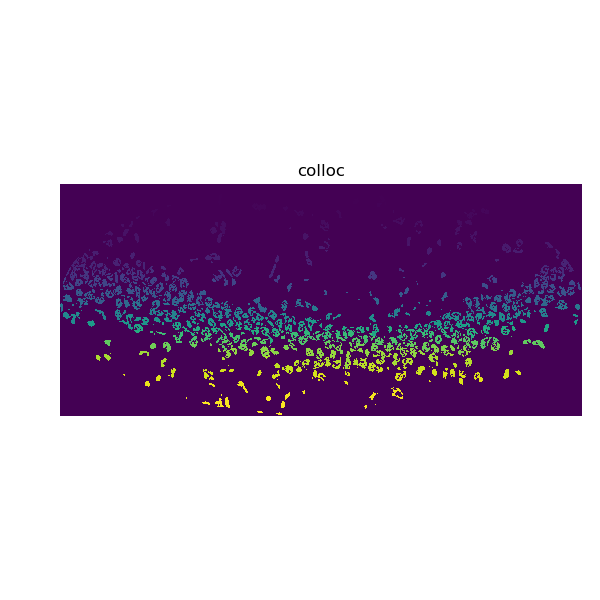

<IPython.core.display.Javascript object>

arc len  0
homer len  0


In [20]:
to_reevalueate = []

arc_pos, arc_mult =  find_ieg_colloc(arc_locations, nuclei, to_reevalueate)
homer_pos, homer_mult =  find_ieg_colloc(homer_locations, nuclei, to_reevalueate)

print('arc len ', len(arc_pos))
print('homer len ', len(homer_pos))



In [13]:
print(len(homer_mult))

0


In [21]:
'''arc_positive = np.array([])
to_reevaluate = np.array([])

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)

for nucleus in nuclei:
    arc_no = 0
    
            
ax.set_axis_off()

fig.tight_layout()
plt.show()'''

'arc_positive = np.array([])\nto_reevaluate = np.array([])\n\nfig, ax = plt.subplots(figsize=(6, 6))\nax.imshow(image)\n\nfor nucleus in nuclei:\n    arc_no = 0\n    \n            \nax.set_axis_off()\n\nfig.tight_layout()\nplt.show()'

In [22]:
def widen_bbox(bbox, margin, shape):
    return (max(bbox[0] - margin, 0), max(bbox[1] - margin, 0),
           min(bbox[0] +margin, shape[0]), min(bbox[1] + margin, shape[1]))

In [23]:
#fig, axes = plt.subplots(nrows = len(regions_to_reconsider), sharex=True, sharey=True,figsize=(15,55))
#ax = axes.ravel()
#plt.ioff()
'''
for reg_to_reev in regions_to_reconsider:
    widened_box = widen_bbox(reg_to_reev.bbox, 50, image.shape)
    dapi_segmentation(image[widened_box[0]:widened_box[2],widened_box[1]:widened_box[3]], 15, 500, sobel_g=True)
'''
    #ax_.imshow(image[widened_box[0]:widened_box[2],widened_box[1]:widened_box[3]])
    #ax_.set_axis_off()

#fig.tight_layout()
#plt.show()

'\nfor reg_to_reev in regions_to_reconsider:\n    widened_box = widen_bbox(reg_to_reev.bbox, 50, image.shape)\n    dapi_segmentation(image[widened_box[0]:widened_box[2],widened_box[1]:widened_box[3]], 15, 500, sobel_g=True)\n'

In [24]:
len(imgs_to_reconsider)

NameError: name 'imgs_to_reconsider' is not defined